# IMPORTS

In [1]:
import torch
import torch.nn as nn
from pymonntorch import Behavior, SynapseGroup, Network, NeuronGroup, Recorder, EventRecorder
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express
import numpy as np
from matplotlib.pyplot import  Button, Slider
import plotly.graph_objects as go
import plotly.express as px

# NEURON SIZES AND NUMBER OF ITEARATIONS

In [2]:
EXC_SIZE1 = 10
EXC_SIZE2 = 2
ITER = 15000

I_EXC_NOISE1 = torch.zeros(size=(ITER,EXC_SIZE1))

I_EXC_NOISE2 = torch.zeros(size=(ITER,EXC_SIZE2))

In [3]:
CURRENT_EXC1 = I_EXC_NOISE1
CURRENT_EXC2 = I_EXC_NOISE2

# POISSON ENCODING

In [4]:
class Poisson():
    
    def __init__(self, time_window, r):
        self.time_window = time_window
        self.r = r
        
    def encode(self, size):
        spikes = torch.rand(size=(self.time_window, size)) * self.r
        p_rand = torch.rand(size=(self.time_window, size))
        self.encode_spikes = (spikes < p_rand).byte()
        self.encode_spikes_2 = (spikes >= p_rand).byte()
        return self.encode_spikes, self.encode_spikes_2
    
    def raster_plot(self):
        plt.figure(figsize=(20,8))
        plt.scatter(torch.nonzero(self.encode_spikes, as_tuple=True)[0], torch.nonzero(self.encode_spikes, as_tuple=True)[1])
        plt.xlabel("Time")
        plt.ylabel("Neurons")
        plt.title('Raster Plot')
        plt.xlim(-1,self.time_window)
        plt.show()

# A PATTERN

# LIF MODEL BEHAVIOR THAT JUST GET THE SPIKE TRAINS

In [5]:
class LIF(Behavior):
    
    def initialize(self, neurons):
        super().initialize(neurons)
        self.add_tag("LIF")
        self.set_parameters_as_variables(neurons)
        neurons.v = neurons.vector("uniform") * (neurons.threshold - neurons.v_reset) * 1.1
        neurons.v += neurons.v_reset
        neurons.spikes = neurons.v > neurons.threshold
        
    def dv_dt(self, neurons):
        leakage = -(neurons.v - neurons.v_rest)
        return ((leakage + (neurons.R * neurons.I)) / neurons.tau) * neurons.dt
        
    def forward(self, neurons):
        neurons.spikes = neurons.spike_iter[neurons.iteration-1].bool()

# COMPUTING CURRENTS THAT COMES FROM THE SPIKES OF PRE-SYNAPTIC NEURONS

In [6]:
class LIF_INPUT(Behavior):
    
    def initialize(self, synapse):
        self.coef = self.parameter("coef", None)
        self.density = self.parameter("density", None)
        torch.manual_seed(42)
        synapse.W = synapse.matrix(mode='uniform', density = self.density)

    def forward(self, synapse):
        spikes = synapse.src.spikes.float()
        # synapse.I = (torch.matmul(synapse.W, spikes) / synapse.src.size) * self.coef
        synapse.I = (torch.matmul(spikes, synapse.W) / synapse.src.size) * self.coef
        # synapse.I = torch.sum(synapse.W[spikes], axis=0) * self.coef

# COMPLETE LIF NEURONS FOR THE SECOND LAYER

In [7]:
class LIF_output(Behavior):
    
    def initialize(self, neurons):
        super().initialize(neurons)
        self.add_tag("LIF")
        self.set_parameters_as_variables(neurons)
        neurons.v = neurons.vector("uniform") * (neurons.threshold - neurons.v_reset) * 1.1
        neurons.v += neurons.v_reset
        neurons.spikes = neurons.v > neurons.threshold
        
    def dv_dt(self, neurons):
        leakage = -(neurons.v - neurons.v_rest)
        return ((leakage + (neurons.R * neurons.I)) / neurons.tau) * neurons.dt
        
    def forward(self, neurons):
        neurons.v[neurons.spikes] = neurons.v_reset
        neurons.v += self.dv_dt(neurons)
        neurons.spikes = neurons.v > neurons.threshold

# DENDRITE COMPUTATION

In [8]:
class Dendrite(Behavior):

    def forward(self, neurons):
        neurons.I = neurons.E_I[neurons.iteration-1]
        for synapse in neurons.afferent_synapses['GLUTAMATE']:
            neurons.I += synapse.I

# TRACE OF NEURONS

In [9]:
class Trace(Behavior):
    
    def initialize(self, synapse):
        self.add_tag("Trace")
        self.tau = self.parameter("tau", None)
        synapse.src.trace = synapse.src.vector(mode="zeros")
        synapse.dst.trace = synapse.dst.vector(mode="zeros")

    def trace(self, synapse):
        d_trace_src = -1 * synapse.src.trace/self.tau + synapse.src.spikes
        d_trace_dst = -1 * synapse.dst.trace/self.tau + synapse.dst.spikes
        return d_trace_src, d_trace_dst
    
    def forward(self, synapse):
        d_trace_src, d_trace_dst = self.trace(synapse)
        synapse.src.trace += d_trace_src
        synapse.dst.trace += d_trace_dst

# SOFTBOUND FUNCTIONS

In [10]:
def softbound_plus(w_max, w, eta_p):
    return (w_max - w) * eta_p

def softbound_minus(w_min, w, eta_m):
    return (w - w_min) * eta_m

def softbound(w, w_max, gamma, beta):
    return gamma * (w_max - w) ** beta

def softbound2(w, w_min, w_max):
    return (w_max - w) * (w - w_min) 

# FLATSTDP WITH SOFTBOUND

In [11]:
class FlatSTDP(Behavior):
    
    def initialize(self, synapse):
        self.add_tag("FlatSTDP")
        self.eta_p = self.parameter("eta_p", None)
        self.eta_m = self.parameter("eta_m", None)
        self.cte_post = self.parameter("cte_post", None)
        self.cte_pre = self.parameter("cte_pre", None)
        self.w_max = self.parameter("w_max", None)
        self.w_min = self.parameter("w_min", None)
        
    def compute_delta_w(self, synapse):
        A_plus = softbound_plus(self.w_max, synapse.W, self.eta_p)
        A_minus = softbound_minus(self.w_min, synapse.W, self.eta_m)
        
        time_stdp_dst = synapse.dst.trace > 0.02
        time_stdp_src = synapse.src.trace > 0.02
        # print(synapse.dst.trace, synapse.src.trace)
        
        dw_plus = torch.outer(time_stdp_src * self.cte_pre, synapse.dst.spikes) * A_plus
        dw_minus = torch.outer(synapse.src.spikes, time_stdp_dst * self.cte_post) * A_minus
        
        # dw_plus = torch.outer(synapse.src.trace, synapse.dst.spikes) * A_plus
        # dw_minus = torch.outer(synapse.src.spikes, synapse.dst.trace) * A_minus
        
        
        synapse.delta_w = dw_plus - dw_minus
        return synapse.delta_w
        
    def forward(self, synapse):
        synapse.W += self.compute_delta_w(synapse)
        synapse.W = torch.clamp(synapse.W, self.w_min, self.w_max)

# FLATSTDP

In [12]:
class FlatSTDP2(Behavior):
    
    def initialize(self, synapse):
        self.add_tag("FlatSTDP")
        self.eta_p = self.parameter("eta_p", None)
        self.eta_m = self.parameter("eta_m", None)
        self.cte_post = self.parameter("cte_post", None)
        self.cte_pre = self.parameter("cte_pre", None)
        self.w_max = self.parameter("w_max", None)
        self.w_min = self.parameter("w_min", None)
        
    def compute_delta_w(self, synapse):
        time_stdp_dst = synapse.dst.trace > 0.1
        time_stdp_src = synapse.src.trace > 0.1
        
        dw_plus = torch.outer(time_stdp_src * self.cte_pre, synapse.dst.spikes) * self.eta_p
        dw_minus = torch.outer(synapse.src.spikes, time_stdp_dst * self.cte_post) * self.eta_m
        
#         dw_plus = torch.outer(synapse.src.trace, synapse.dst.spikes) * self.eta_p \
#         * softbound2(synapse.W, self.w_min, self.w_max)
        
#         dw_minus = torch.outer(synapse.src.spikes, synapse.dst.trace) * self.eta_m \
#         * softbound2(synapse.W, self.w_min, self.w_max)
        
        synapse.delta_w = (dw_plus - dw_minus)
        return synapse.delta_w
        
    def forward(self, synapse):
        delta = self.compute_delta_w(synapse)
        synapse.W += delta
        synapse.W = torch.clamp(synapse.W, self.w_min, self.w_max)

In [13]:
dopamine_trace = []

# DOPAMINE NEURO-MODULATOR AND R/P PROCESS

In [14]:
class Dopamine(Behavior):
    
    def initialize(self, network):
        self.add_tag("Dopamine")
        self.tau_dopamine = self.parameter("tau_dopamine", None)
        network.dopamine = self.parameter("baseline_dopamine", 1.0)
        
    def _dd_dt(self, network):
        self.dst_spikes = network.find_objects('GLUTAMATE')[0].dst.spikes
        self.src_spikes = network.find_objects('GLUTAMATE')[0].src.spikes
        
        flag = False  # second signal
        r_p = 0
        for i in self.src_spikes[:EXC_SIZE1 // 2]:
            if i == True:
                flag = True  # first signal
                
            # first neuron will learn the first signal and the second neuron will learn the second pattern
        if (not self.dst_spikes[0]) and (not self.dst_spikes[1]):
            r_p = 0
        elif (self.dst_spikes[0]) and (self.dst_spikes[1]):
            r_p = -0.4
        elif (flag) and (self.dst_spikes[0]):
            r_p = 1
        elif (not flag) and (self.dst_spikes[1]):
            r_p = 1
        else:
            r_p = -1
        
        return -(network.dopamine / self.tau_dopamine) + r_p
        
    def forward(self, network):
        global dopamine_trace
        dd_dt = self._dd_dt(network)
        network.dopamine += dd_dt
        dopamine_trace.append(network.dopamine)

# FLATRSTDP

In [15]:
class FlatRSTDP(FlatSTDP2):
    
    def initialize(self, synapse):
        super().initialize(synapse)
        self.add_tag("FlatRSTDP")
        self.tau_c = self.parameter("tau_c", None)
        synapse.c = synapse.matrix(mode = "zeros")
        
    def dc_dt(self, synapse):
        stdp = self.compute_delta_w(synapse)
        # print(stdp)
        c = (-synapse.c / self.tau_c) + stdp
        return c
    
    def forward(self, synapse):
        c = self.dc_dt(synapse)
        synapse.c += c
        synapse.W += (synapse.c * synapse.network.dopamine)
        synapse.W = torch.clamp(synapse.W, self.w_min, self.w_max)
        # print(synapse.c * synapse.network.dopamine)

# A PATTERN

# A PATTERN

In [16]:
x1 = torch.tensor([1., 1., 1., 1., 1., 0, 0, 0, 0, 0])
x2 = x1.flip(0)
time = ITER
j=0
x=[x1,x2]
pattern_non = torch.zeros((50, EXC_SIZE1))
pattern = torch.zeros((1, EXC_SIZE1))
for i in range(time):
    j += 1
    if j==100:
        j=0
        x = x[::-1]
    y = x[0]
    y = torch.poisson(y) > 0
    y = torch.unsqueeze(y.byte(), 0)
    pattern = torch.cat([pattern, y], 0)
pattern = pattern[1:]

In [17]:
pattern.shape

torch.Size([15000, 10])

# PARAMETERS OF MODEL

In [18]:
pop_params1 = {
    "spike_iter" : pattern,
    "E_I" : CURRENT_EXC1,
    "v_reset" : -75,
    "dt" : 1,
    "v_rest": -67,
    "tau" : 10,
    "R" : 5,
    "threshold" : -37,
}

pop_params2 = {
    "E_I" : CURRENT_EXC2,
    "v_reset" : -75.0,
    "dt" : 1.,
    "v_rest": -67.0,
    "tau" : 10.,
    "R" : 5.,
    "threshold" : -37.,
}

# CONSTRUCTING MODEL WITH TWO NEURON GROUPS AND A SYNAPSE GROUP (PARAMETERS OF STDP & RSTDP ARE DEFINES HERE)

In [19]:
settings = {"def_type": torch.float32, "device": 'cpu', "synapse_mode": False}
net = Network(settings = settings, behavior={
                                        5: Dopamine(tau_dopamine=10., baseline_dopamine=2.),
                                        # 10: Recorder(["n.dopamine"], auto_annotate=False)  
                                        })
ng_exc1 = NeuronGroup(
    net=net,
    size=EXC_SIZE1,
    tag="exc_neurons1",
    behavior={
        3: Dendrite(),
        5: LIF(**pop_params1),
        9: Recorder(["n.v","n.I"], auto_annotate=False),
        10: EventRecorder(["spikes"]),
    },
)

ng_exc2 = NeuronGroup(
    net=net,
    size=EXC_SIZE2,
    tag="exc_neurons2",
    behavior={
        3: Dendrite(),
        5: LIF_output(**pop_params2),
        9: Recorder(["n.v", "n.I"], auto_annotate=False),
        10: EventRecorder(["spikes"]),
    },
)


syn1 = SynapseGroup(src=ng_exc1, dst=ng_exc2, net=net, tag="GLUTAMATE", behavior={
                                2: LIF_INPUT(coef=200, density=1),
                                4: Trace(tau=15.),
                                # 7: FlatSTDP(eta_p=0.32, eta_m=0.3, cte_post=0.005, cte_pre=0.005, w_max=1, w_min=0),
                                # 7: FlatSTDP2(eta_p=0.310, eta_m=0.301, cte_post=0.0065, cte_pre=0.05, w_max=1, w_min=0),
                                6: FlatRSTDP(eta_p=0.320, eta_m=0.301, cte_post=0.00045, cte_pre=0.00045, w_max=1, w_min=0,
                                            tau_c = 1200.),
                                10: Recorder(["s.delta_w", 's.W'], auto_annotate=False),
                                11: Recorder(['s.c'], auto_annotate=False)  # for rstdp
})


net.initialize()
net.simulate_iterations(ITER)

Network['Network'](Neurons: tensor(12)|2 groups, Synapses: tensor(20)|1 groups){5:Dopamine(tau_dopamine=10.0,baseline_dopamine=2.0,)}
NeuronGroup['exc_neurons1', 'NeuronGroup', 'ng'](10){3:Dendrite()5:LIF(spike_iter=tensor([[1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [1., 1., 0.,  ..., 0., 0., 0.]]),E_I=tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]),v_reset=-75,dt=1,v_rest=-67,tau=10,R=5,threshold=-37,)9:Recorder(auto_annotate=False,arg_0=['n.v', 'n.I'],)10:EventRecorder(arg_0=['spikes'],)}
NeuronGroup['exc_neurons2', 'NeuronGroup', 'ng'](2){3:Dendrite()5:LIF_output(E_I=tensor([[0., 0.],
        [0., 0.],
        [0.

10267.937898635864

# DOPAMINE TRACE

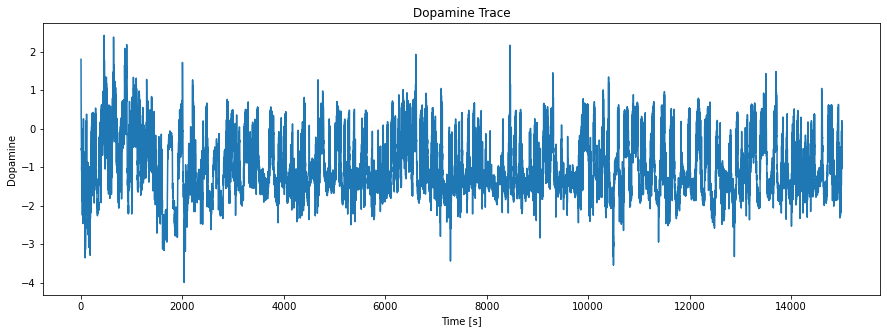

In [28]:
plt.figure(figsize=(15,5))
plt.plot(dopamine_trace)
plt.ylabel("Dopamine")
plt.xlabel("Time [s]")
plt.title("Dopamine Trace")
plt.show()

# RASTER PLOT OF THE TWO LAYERS

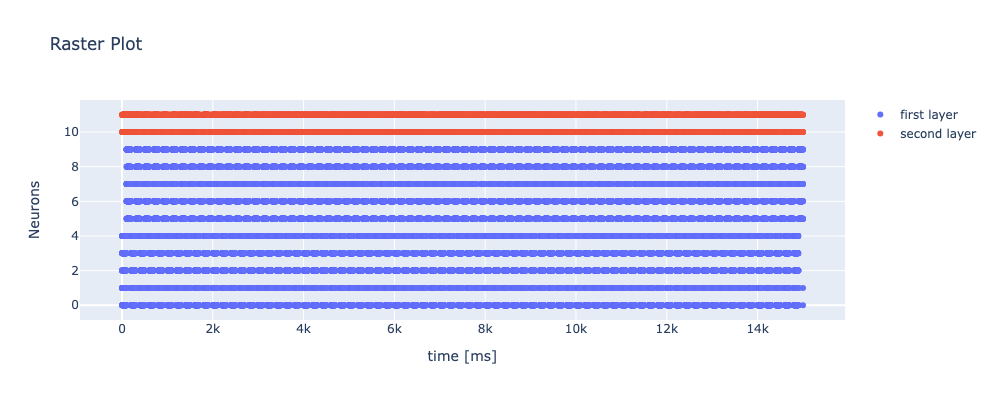

In [29]:
x1 = net["exc_neurons1",0]["spikes",0][:,0]
y1 = net["exc_neurons1",0]["spikes",0][:,1]
x2 = net["exc_neurons2",0]["spikes",0][:,0]
y2 = net["exc_neurons2",0]["spikes",0][:,1]+EXC_SIZE1

f2 = go.Figure(
    data = [
        go.Scatter(x=x1, y=y1, name="first layer", mode="markers"),
        go.Scatter(x=x2, y=y2, name="second layer", mode="markers"),
    ],
    layout = {"xaxis": {"title": "time [ms]"},"yaxis": {"title": "Neurons"}, "title": "Raster Plot"}
)
f2.update_layout(
    autosize=False,
    width=1000,
    height=400)
f2

In [23]:
syn1['s.delta_w', 0][4]

tensor([[ 0.0000,  0.0000],
        [-0.0001, -0.0001],
        [-0.0001, -0.0001],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000]])

# PLOTTING CHANGES OF WEIGHTS 

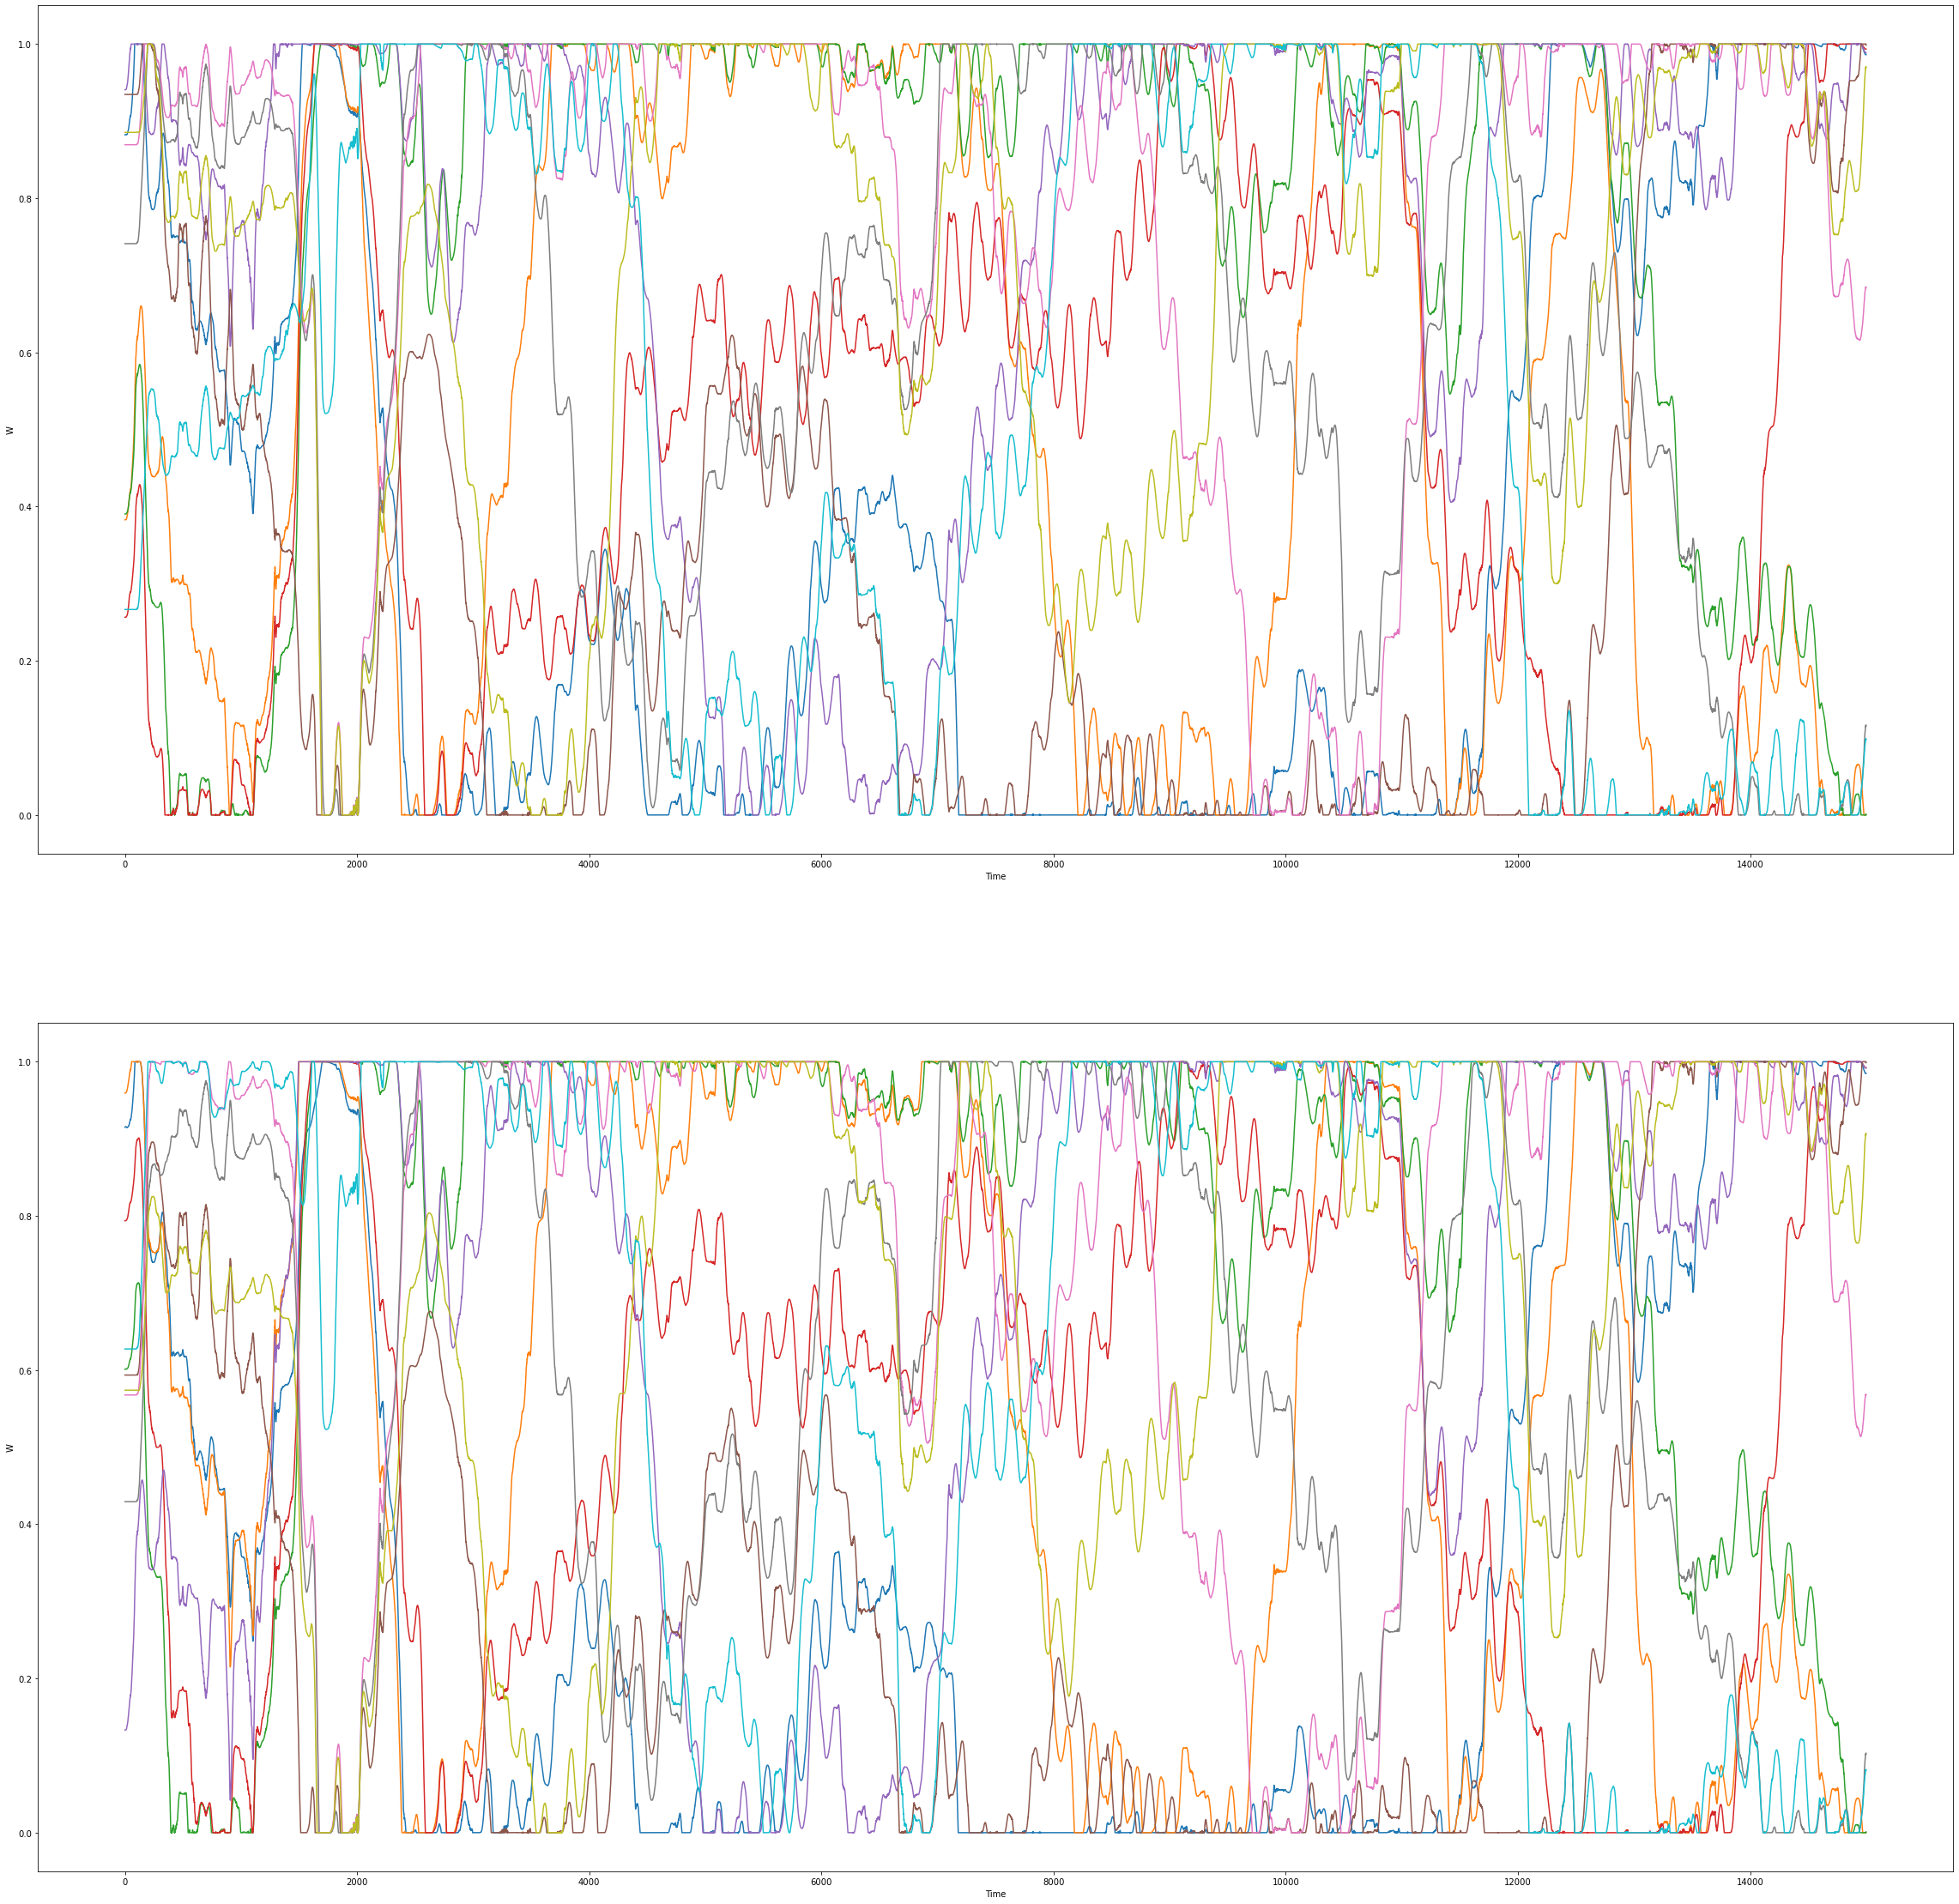

In [24]:
fig, axs = plt.subplots(EXC_SIZE2, figsize=(40,40))
time = np.arange(0, ITER, 1)

for i in range(EXC_SIZE2):
    for j in range(EXC_SIZE1):
        w = syn1['s.W', 0][:, j, i]
        axs[i].plot(time, w)
        axs[i].set(xlabel="Time", ylabel="W")
plt.show()

In [25]:
syn1['s.W', 0][1999]

tensor([[0.9063, 0.9321],
        [0.9119, 0.9498],
        [0.9953, 0.9986],
        [0.9918, 0.9974],
        [0.9992, 0.9997],
        [0.0129, 0.0137],
        [0.0188, 0.0196],
        [0.0170, 0.0175],
        [0.0170, 0.0170],
        [0.8858, 0.8499]])

# PLOTTING CHANGES OF WEIGHTS

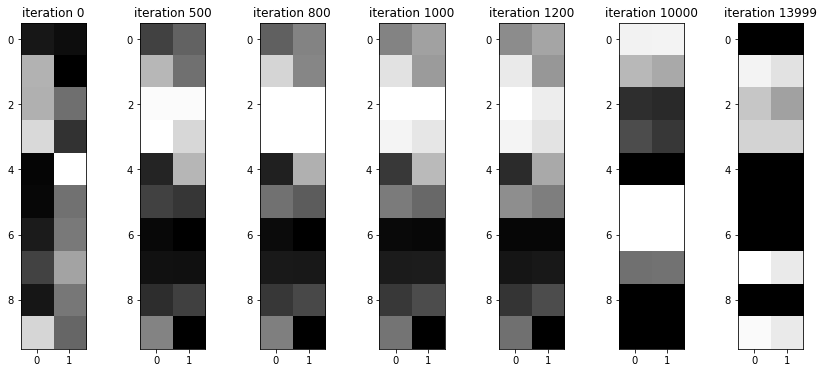

In [26]:
fig, axs = plt.subplots(1,7, figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()
its = [0, 500, 800, 1000, 1200, 10000, 13999]
for i in range(len(its)):
    axs[i].imshow(syn1['s.W', 0][its[i]], cmap='gray_r')
    axs[i].set_title("iteration " + str(its[i]))

# PLOTTING CHANGES OF SYNAPTIC GAP

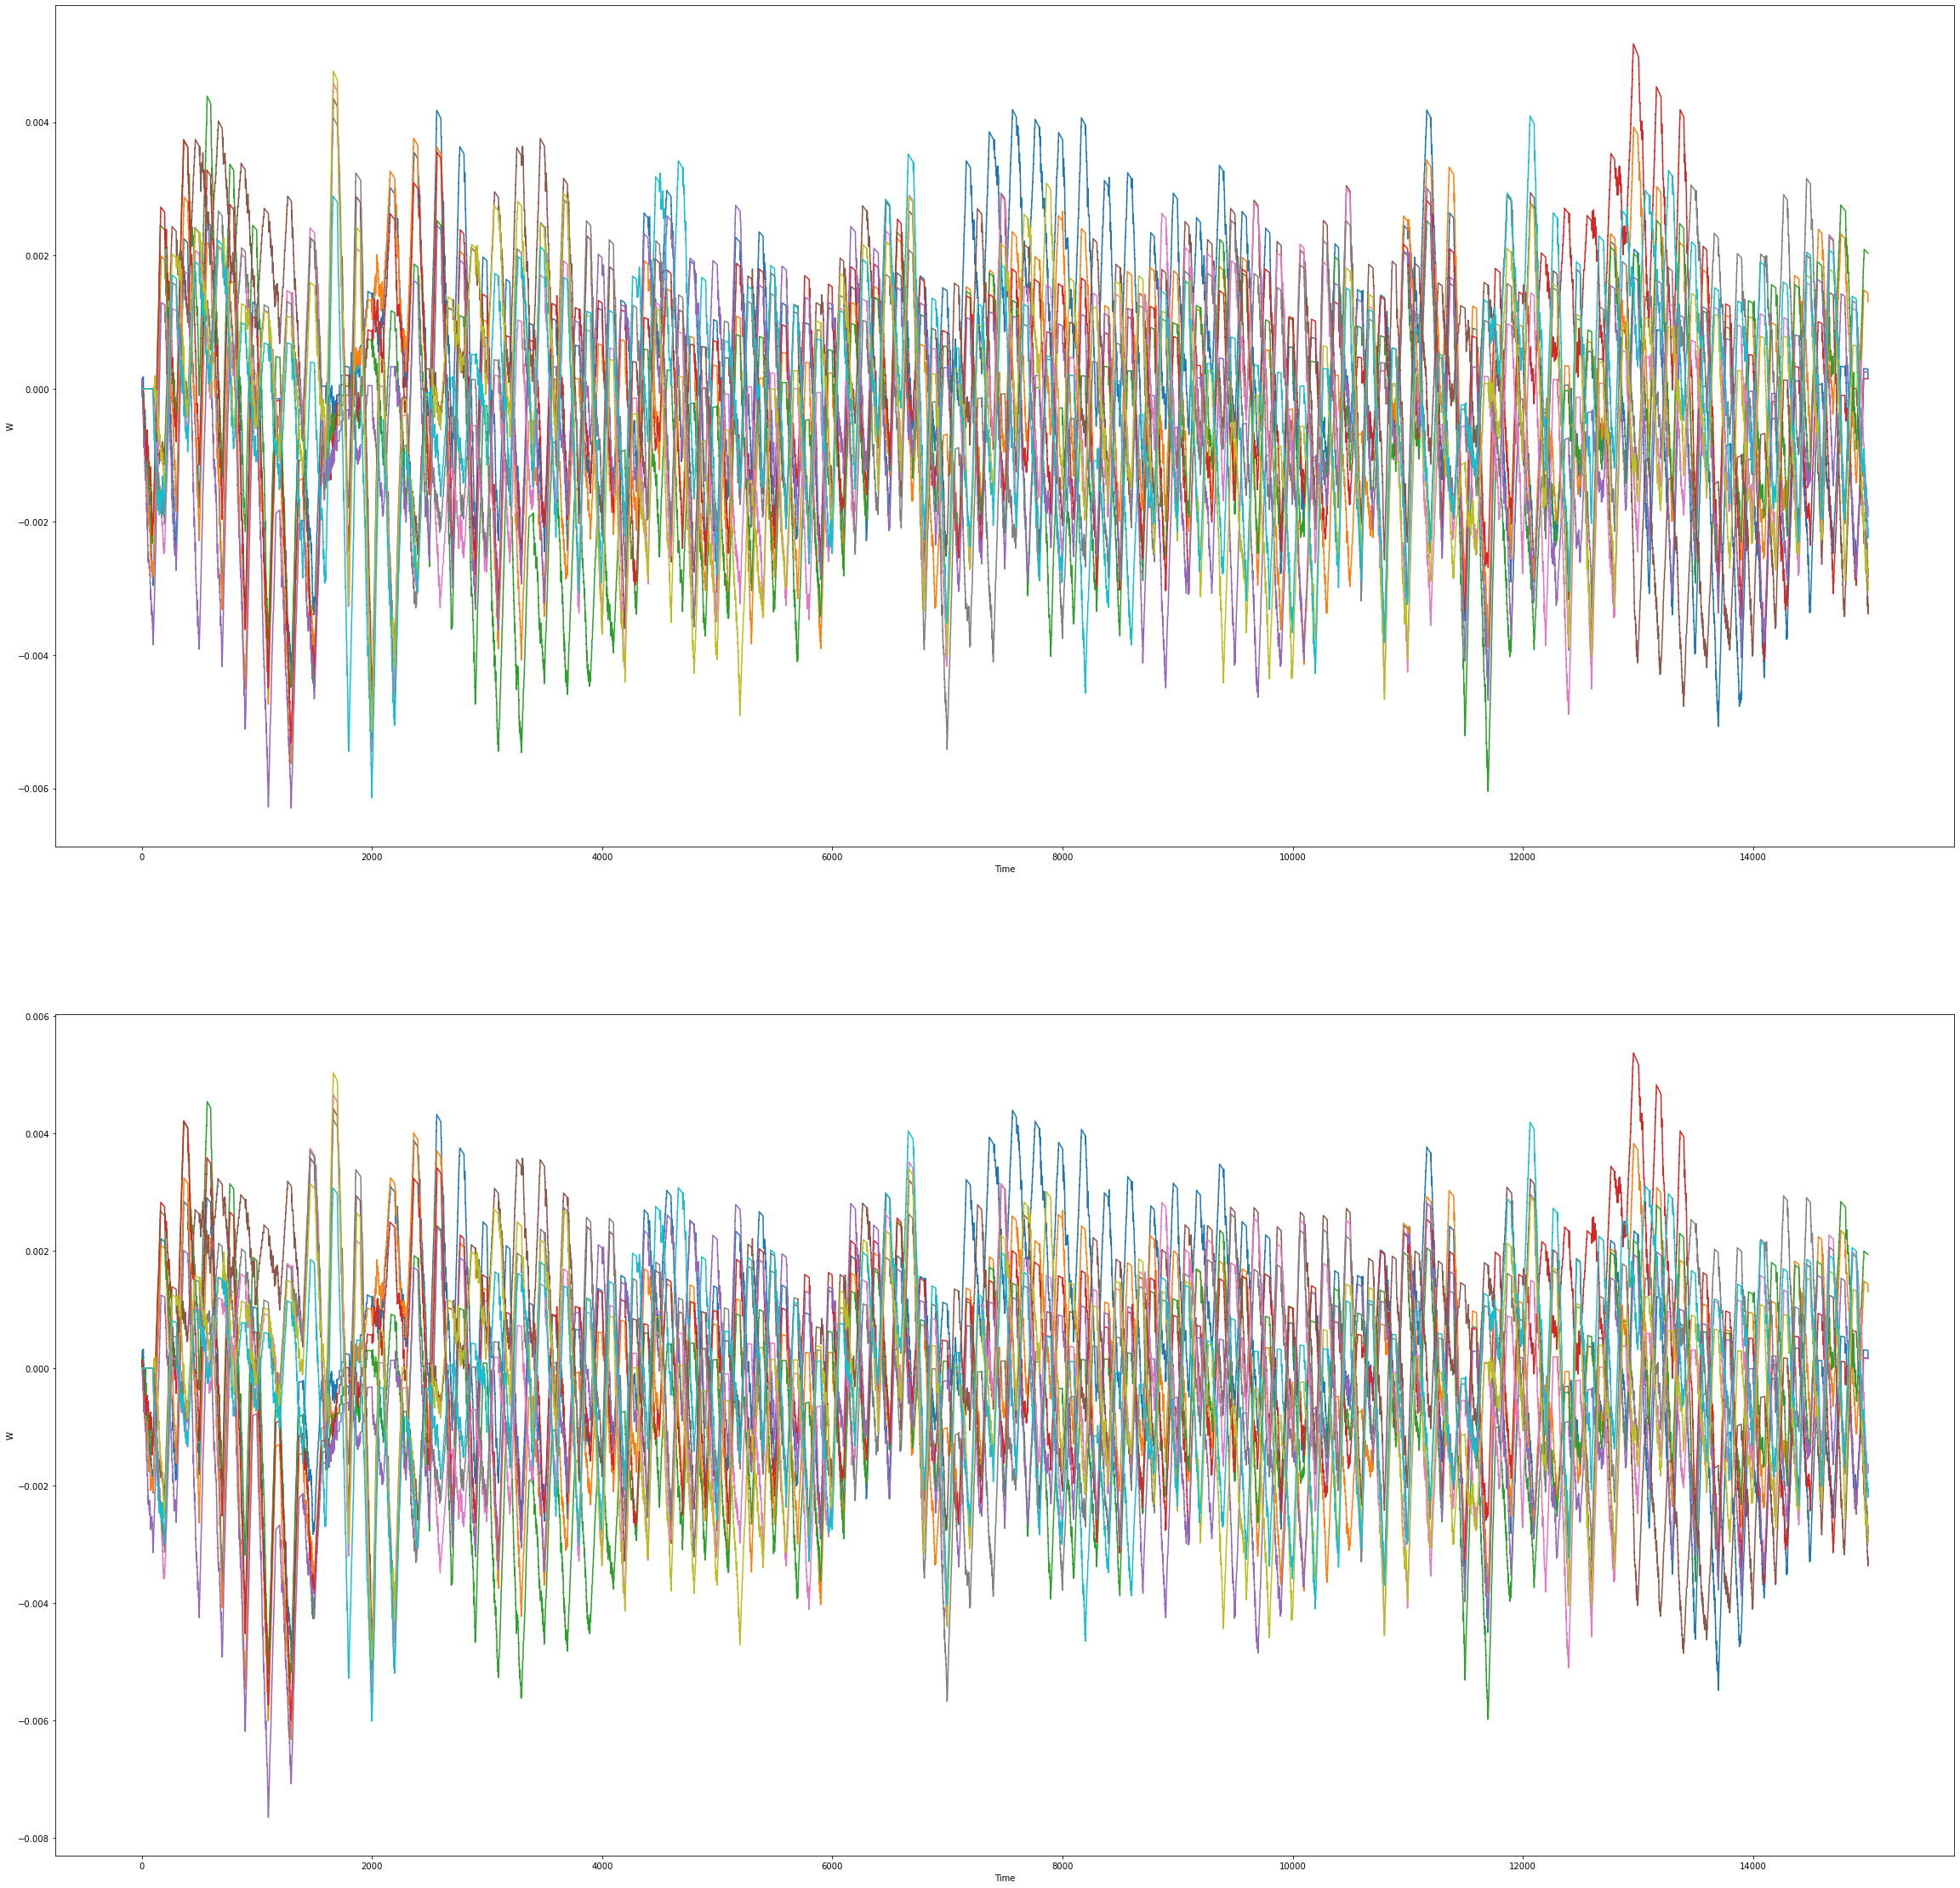

In [27]:
fig, axs = plt.subplots(EXC_SIZE2, figsize=(40,40))
time = np.arange(0, ITER, 1)

for i in range(EXC_SIZE2):
    for j in range(EXC_SIZE1):
        w = syn1['s.c',  0][:, j, i]
        axs[i].plot(time, w)
        axs[i].set(xlabel="Time", ylabel="W")
plt.show()